# Compute gcorr diseases and phenotypes (ldscr)
###### Created 03/08/2022
###### Last modification 10/10/2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import glob, os
from os import listdir
from os.path import isfile, join
from datetime import datetime

In [36]:
high_med_conf= True

if high_med_conf:
    diseases_traits = {
        '4079':'DBP',
        '4080':'SBP',
        #'102':'PR',
        '30760':'HDL cholesterol',
        '1558':'Alcohol intake freq',
        '21021':'Pulse wave arterial stiffness',
        '30780':'LDL direct',
        '30870':'Triglycerides'
        }

else:
    diseases_traits = {
        '4079':'DBP',
        '4080':'SBP',
        #'102':'PR',
        '1558':'Alcohol intake freq',
        '21021':'Pulse wave arterial stiffness',
        #'40000':'Date death',
        #'42020':'Date AD',
        '30760':'HDL cholesterol',
        '30780':'LDL direct',
        '30870':'Triglycerides',
        '2976':'Age diabetes',
        '3627':'Age angina',
        '3894':'Age heart attack',
        '4012':'Age DVT',
        '4056':'Age stroke',
        '40007':'Age death',
        #'4689':'Age glaucoma',
        '4700':'Age cataract',
        #'5408':'Amblyopia',
        '5610_1':'Presbyopia 1',
        '5610_2':'Presbyopia 2',
        '5610_3':'Presbyopia 3',
        '5832_3':'Hypermetropia 3',
        '5843_1':'Myopia 1',
        '5843_2':'Myopia 2',
        '5843_3':'Myopia 3',
        '5855_1':'Astigmatism 1',
        '5855_2':'Astigmatism 2',
        '5855_3':'Astigmatism 3',   
        #'5890':'Diabetes eye',
        #'5945':'Eye other',
        '1717':'Skin colour',
        '1747_1':'Hair colour 1',
        '1747_2':'Hair colour 2',
        '1747_3':'Hair colour 3',
        '1747_4':'Hair colour 4',
        '1747_5':'Hair colour 5',
        '1747_6':'Hair colour 6'
        #'4022':'Age pulmonary embolism',
        #'131380':'Circulatory sys dis',
        #'131390':'Other art dis'
        }

#KeyError: "['4022', '4689', '5890', '5945', '131380', '131390', '42020', '5408', '40000', '102'] not in index"

traits_all = list(diseases_traits.keys())
traits_phenos_new = list(diseases_traits.values())

In [37]:
# path This we can read from config
def try_to_compute_all(traits_all):
    path = '/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/gcorr_diseases/2022_08_03_ventile5/'
    save_path = path
    l_diseases_all=[]
    for trait in traits_all:
        #print(trait)
        for file in os.listdir(path):
            #print(file, '\n')
            if file.startswith(trait):
                if file.endswith('.tsv'):
                    #print('PHENO', trait)
                    #print(file, '\n')
                    df_ss = pd.read_csv(path + file,  nrows=1, sep='\t')
                    #print(df_ss['N'].iloc[0])
                    print(file)
                    data={
                        'pheno':  trait,
                        'file':  file
                        #,'N': df_ss['N'].iloc[0],
                        }
                    l_diseases_all.append(data)

    df_diseases_all =pd.DataFrame(l_diseases_all)
    #file_name_end = '_irnt.gwas.imputed_v3.both_sexes.tsv'
    
    ## traits_phenos This we can read from config
    traits_phenos = ["DF_artery" , "DF_vein" , "D_A_std" , "D_V_std" ,
                    "bifurcations" , "VD_orig_artery" , "VD_orig_vein" , "ratio_VD" , 
                    "mean_angle_taa" , "mean_angle_tva" , "eq_CRAE" , "eq_CRVE" , 
                     "ratio_CRAE_CRVE", "medianDiameter_artery" , "medianDiameter_vein" , "ratio_AV_medianDiameter", "ratio_AV_DF"]

    l_traits_file=[]
    for trait in traits_phenos:
        file_pheno= trait + '__munged.sumstats.gz'
        l_traits_file.append(file_pheno)

    type_sex='both_sexes'

    traits_files = l_traits_file + list(df_diseases_all['file'])
    traits_names = traits_phenos + list(df_diseases_all['pheno'])
    print(len(traits_files), len(l_traits_file), len(list(df_diseases_all['file'])))
    return df_diseases_all

df_diseases_all = try_to_compute_all(traits_all)

4079_irnt.ldsc.imputed_v3.both_sexes.tsv
4080_irnt.ldsc.imputed_v3.both_sexes.tsv
30760_irnt.imputed_v3.ldsc.both_sexes.tsv
1558.ldsc.imputed_v3.both_sexes.tsv
21021_irnt.ldsc.imputed_v3.both_sexes.tsv
30780_irnt.imputed_v3.ldsc.both_sexes.tsv
30870_irnt.imputed_v3.ldsc.both_sexes.tsv
24 17 7


In [38]:
df_diseases_all.head(5)

,pheno,file
0,4079,4079_irnt.ldsc.imputed_v3.both_sexes.tsv
1,4080,4080_irnt.ldsc.imputed_v3.both_sexes.tsv
2,30760,30760_irnt.imputed_v3.ldsc.both_sexes.tsv
3,1558,1558.ldsc.imputed_v3.both_sexes.tsv
4,21021,21021_irnt.ldsc.imputed_v3.both_sexes.tsv


In [81]:
traits_reduced = list(diseases_traits.keys())


traits_phenos = ["DF_artery" , "DF_vein" , "D_A_std" , "D_V_std" ,
                    "bifurcations" , "VD_orig_artery" , "VD_orig_vein" , "ratio_VD" , 
                    "mean_angle_taa" , "mean_angle_tva" , "eq_CRAE" , "eq_CRVE" , 
                     "ratio_CRAE_CRVE", "medianDiameter_artery" , "medianDiameter_vein" , 
                 "ratio_AV_medianDiameter", "ratio_AV_DF"]

traits_phenos_new= ["DF_artery" , "DF_vein" , "D_A_std" , "D_V_std" ,
                    "bifurcations" , "VD_orig_artery" , "VD_orig_vein" , "ratio_VD" , 
                    "mean_angle_taa" , "mean_angle_tva" , "eq_CRAE" , "eq_CRVE" , 
                     "ratio_CRAE_CRVE", "medianDiameter_artery" , "medianDiameter_vein" , 
                 "ratio_AV_medianDiameter", "ratio_AV_DF"]


#datafields_irnt = [ dat + "_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz" for dat in traits_reduced]
datafields_irnt = [ dat for dat in df_diseases_all['file']]
datafields_pheno = [ dat + "__munged.sumstats.gz" for dat in traits_phenos]
diseasess_tra_aux = [ dat for dat in df_diseases_all['pheno']]

traits_col_index = traits_phenos + diseasess_tra_aux
traits_names = datafields_pheno + datafields_irnt

In [82]:
### IMPORTANT: If you have not same file go back to diseases_traits and comment 
### the phenotypes that are missing

In [83]:
# filter the files names containing 2 traits
path = '/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/gcorr_diseases/2022_08_03_ventile5/'
# filter the files names containing 2 traits
def read_ldsr(traits_files, traits_col_index):
    df_cov=pd.DataFrame(columns =traits_col_index, index=traits_col_index)
    df_corr=pd.DataFrame(columns =traits_col_index, index=traits_col_index)
    df_std=pd.DataFrame(columns =traits_col_index, index=traits_col_index)
    #2976_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz_4700_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz.log
    #2976_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz_D_A_std__munged.sumstats.gz.log

    for i  in range(len(traits_files)):
        for j in range(len(traits_files)):
            h2 = []
            file_both_name = traits_files[i]+'_'+ traits_files[j]+'.log'
            dir_traitsfile = path+file_both_name
            #print(dir_traitsfile)
            with open(dir_traitsfile) as fp:
                #print(fp)
                #print(traits_files[i],traits_files[j])
                Lines = fp.readlines()
                for line in Lines:
                    #print(line)
                    split = line.split()
                    if('gencov:' in split):
                        df_cov.iloc[i][j] = round(float(split[ split.index('gencov:') +1 ]),3)
                        df_cov.iloc[j][i] = round(float(split[ split.index('gencov:') +1 ]),3)
                        #print(split)
                    if('Correlation:' in split):
                        #print(line)
                        #print(split)
                        df_corr.iloc[i][j] = round(float(split[ split.index('Correlation:') +1 ]),3)
                        df_corr.iloc[j][i] = round(float(split[ split.index('Correlation:') +1 ]),3)
                        #print(array2)
                        #print(split )
                        #print( df_corr.iloc[i][j], float(split[ split.index('Correlation:') +1 ]) )
                        #print( df_corr.iloc[j][i], float(split[ split.index('Correlation:') +1 ]))
                        df_std.iloc[i][j] = split[3]
                        df_std.iloc[j][i] = split[3]
    return df_cov, df_corr, df_std

df_cov, df_corr, df_std2 = read_ldsr(traits_names, traits_col_index)     

In [84]:
def rename_col_index(df, l_diseases_old, l_diseases_new, l_phenos_old, l_phenos_new):
    df.rename(columns=dict(zip(l_diseases_old, l_diseases_new)), inplace=True)
    df.rename(index=dict(zip(l_diseases_old, l_diseases_new)), inplace=True)
    return df

def detele_col_index(df, l_cols_delete, l_rows_delete, l_diseases_new, l_phenos_old, l_phenos_new):
    df=df.drop(columns=l_cols_delete)
    df=df.drop(index=l_rows_delete)
    df= rename_col_index(df, l_rows_delete, l_diseases_new, l_phenos_old, l_phenos_new)
    
    return df


df_corr_simpl= detele_col_index(df_corr, traits_phenos, traits_reduced, list(diseases_traits.values()),traits_phenos, traits_phenos_new)
df_std_simpl = detele_col_index(df_std2,  traits_phenos, traits_reduced, list(diseases_traits.values()), traits_phenos, traits_phenos_new)
df_corr_simpl

,DBP,SBP,HDL cholesterol,Alcohol intake freq,Pulse wave arterial stiffness,LDL direct,Triglycerides
DF_artery,-0.039,-0.076,-0.016,-0.01,0.021,-0.013,-0.028
DF_vein,-0.024,-0.098,0.059,-0.074,-0.002,0.048,-0.005
D_A_std,0.122,0.11,0.047,-0.072,0.007,-0.012,-0.025
D_V_std,-0.128,-0.072,0.11,-0.089,-0.178,-0.042,-0.035
bifurcations,0.103,0.138,-0.009,-0.017,0.102,0.04,0.027
VD_orig_artery,0.202,0.204,-0.027,-0.018,0.115,-0.027,0.031
VD_orig_vein,-0.002,0.042,0.003,-0.031,0.019,0.028,0.031
ratio_VD,0.286,0.219,-0.03,-0.006,0.162,-0.051,-0.004
mean_angle_taa,-0.049,-0.015,0.053,-0.05,0.019,0.006,-0.047
mean_angle_tva,-0.09,-0.053,0.058,-0.043,-0.103,0.014,-0.062


In [85]:
### Round the std values
for col in df_std_simpl.columns:
    df_std_simpl[col] = df_std_simpl[col].str.replace("(", "", regex=True)
    df_std_simpl[col] = df_std_simpl[col].str.replace(")", "", regex=True)

df_std_simpl = df_std_simpl.astype(float)
df_std_simpl = df_std_simpl.round(3)
df_std_simpl

,DBP,SBP,HDL cholesterol,Alcohol intake freq,Pulse wave arterial stiffness,LDL direct,Triglycerides
DF_artery,0.031,0.030,0.028,0.028,0.051,0.044,0.026
DF_vein,0.033,0.032,0.028,0.034,0.057,0.048,0.029
D_A_std,0.032,0.031,0.027,0.032,0.054,0.042,0.028
D_V_std,0.042,0.043,0.025,0.030,0.062,0.069,0.049
bifurcations,0.034,0.034,0.033,0.033,0.060,0.050,0.030
VD_orig_artery,0.033,0.034,0.031,0.035,0.061,0.047,0.028
VD_orig_vein,0.033,0.032,0.033,0.031,0.057,0.049,0.028
ratio_VD,0.038,0.038,0.032,0.040,0.076,0.056,0.035
mean_angle_taa,0.039,0.035,0.031,0.039,0.086,0.062,0.036
mean_angle_tva,0.035,0.034,0.033,0.035,0.072,0.059,0.038


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


todo ok


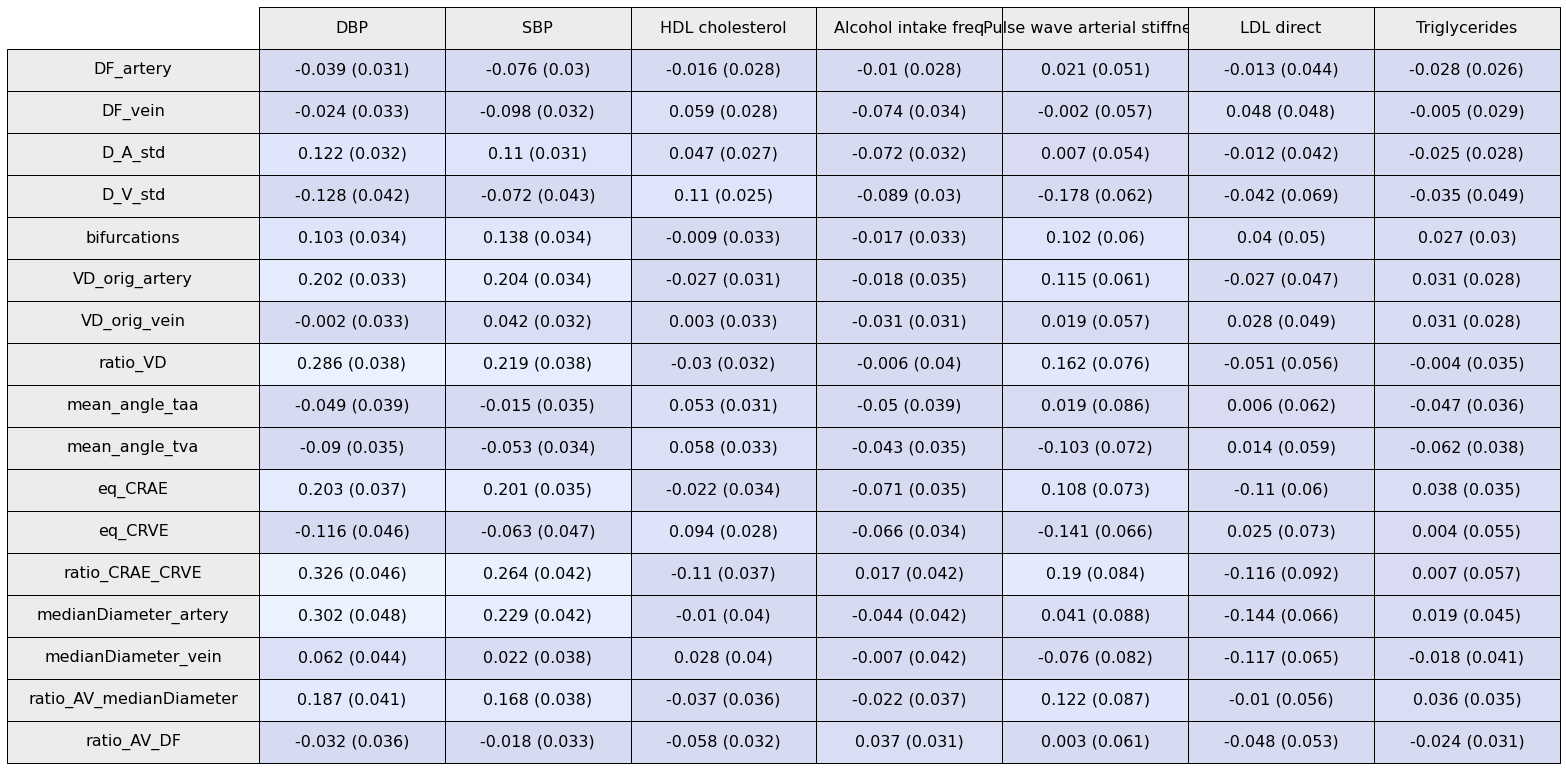

In [97]:
#print(df_reducida.columns, df_std.columns)
df = df_corr_simpl.astype(str) + ' (' + df_std_simpl.astype(str)+ ')'

df_corr_simpl_aux = df_corr_simpl.copy()
df_corr_simpl_aux = df_corr_simpl_aux.astype(float)

rcolors = plt.cm.Greys(np.full(len(df.index), 0.15))
ccolors = plt.cm.Greys(np.full(len(df.columns), 0.15))
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
#create table
table = ax.table(cellText=df.values, 
                 rowColours=rcolors,
                 colLabels=df.columns, 
                 rowLabels=df.index,
                 colColours=ccolors,
                 rowLoc='center',
                 colLoc='center',
                 cellLoc='center',
                 cellColours=plt.cm.coolwarm(df_corr_simpl_aux.values, alpha=0.2),
                 loc='center',
                 fontsize=16,
                 colWidths=[0.15 for x in df.columns])
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(3.7, 3.5) # make table a little bit larger
fig.tight_layout()
#plt.show()
#fig.savefig(save_dir+str(DATE)+'_'+'ventile'+str(ventile_num)+'_diseases_gcorr.pdf', bbox_inches='tight',dpi=250)



print('todo ok')

In [95]:

df_corr_simpl.values

array([[-0.039, -0.076, -0.016, -0.01 ,  0.021, -0.013, -0.028],
       [-0.024, -0.098,  0.059, -0.074, -0.002,  0.048, -0.005],
       [ 0.122,  0.11 ,  0.047, -0.072,  0.007, -0.012, -0.025],
       [-0.128, -0.072,  0.11 , -0.089, -0.178, -0.042, -0.035],
       [ 0.103,  0.138, -0.009, -0.017,  0.102,  0.04 ,  0.027],
       [ 0.202,  0.204, -0.027, -0.018,  0.115, -0.027,  0.031],
       [-0.002,  0.042,  0.003, -0.031,  0.019,  0.028,  0.031],
       [ 0.286,  0.219, -0.03 , -0.006,  0.162, -0.051, -0.004],
       [-0.049, -0.015,  0.053, -0.05 ,  0.019,  0.006, -0.047],
       [-0.09 , -0.053,  0.058, -0.043, -0.103,  0.014, -0.062],
       [ 0.203,  0.201, -0.022, -0.071,  0.108, -0.11 ,  0.038],
       [-0.116, -0.063,  0.094, -0.066, -0.141,  0.025,  0.004],
       [ 0.326,  0.264, -0.11 ,  0.017,  0.19 , -0.116,  0.007],
       [ 0.302,  0.229, -0.01 , -0.044,  0.041, -0.144,  0.019],
       [ 0.062,  0.022,  0.028, -0.007, -0.076, -0.117, -0.018],
       [ 0.187,  0.168, -

# HASTA AQUI!

In [122]:

##### PLOT
#plt.figure(figsize=(50,50))
##plt.figure(figsize=(10,10))
#sb.heatmap(abs(df_corr),cmap="Blues",annot=True)
####sb.heatmap(df2,vmin=0, vmax=1,cmap="Blues",annot=True)
#plt.title('Genetic Correlation')
#plt.savefig(save_dir+str(DATE)+'_'+'ventile'+str(ventile_num)+'_all_heatmap_diseases_gcorr.pdf', bbox_inches='tight', dpi=250)

In [63]:
ventile_num=5
DATE = datetime.now().strftime("%Y-%m-%d")

ventile_num= 5 #sys.argv[1]
save_dir= '/SSD/home/sofia/retina-phenotypes/complementary/GWAS_postprocessing/ldsr_correlation/'

df_corr = df_corr.astype(float)

In [75]:
df_reducida = df_corr[traits_reduced]
df_reducida= df_reducida.drop(index=traits_reduced) 
#df_reducida

df_std =df_std2
df_std= df_std[traits_reduced]
df_std= df_std.drop(index=traits_reduced)
df_std.rename(columns=dict(zip(list(diseases_traits.keys()), list(diseases_traits.values()))), inplace=True)
#df_std.rename(index=dict(zip(traits_phenos, traits_phenos_new)), inplace=True)

df_reducida.rename(columns=dict(zip(list(diseases_traits.keys()), list(diseases_traits.values()))), inplace=True)
#df_reducida.rename(index=dict(zip(traits_phenos, traits_phenos_new)), inplace=True)
df_reducida= df_reducida.round(2)
df_reducida.rename(columns=dict(zip(list(diseases_traits.keys()), list(diseases_traits.values()))), inplace=True)
#df_reducida.rename(index=dict(zip(traits_phenos, traits_phenos_new)), inplace=True)
df_reducida

,DBP,SBP,Alcohol intake freq,Pulse wave arterial stiffness,HDL cholesterol,LDL direct,Triglycerides,Age diabetes,Age angina,Age heart attack,...,Astigmatism 1,Astigmatism 2,Astigmatism 3,Skin colour,Hair colour 1,Hair colour 2,Hair colour 3,Hair colour 4,Hair colour 5,Hair colour 6
DF_artery,-0.04,-0.08,-0.01,0.02,-0.02,-0.01,-0.03,-0.16,0.24,0.22,...,-0.01,-0.20,0.13,0.01,0.02,-0.00,0.03,-0.03,0.02,-0.01
DF_vein,-0.02,-0.10,-0.07,-0.00,0.06,0.05,-0.01,-0.15,0.02,0.03,...,0.07,0.08,-0.12,0.00,0.00,0.02,-0.01,-0.00,-0.03,-0.07
D_A_std,0.12,0.11,-0.07,0.01,0.05,-0.01,-0.02,-0.21,-0.05,0.22,...,0.01,-0.25,0.13,-0.06,0.03,0.03,0.10,-0.05,-0.07,-0.27
D_V_std,-0.13,-0.07,-0.09,-0.18,0.11,-0.04,-0.03,-0.34,0.20,0.11,...,-0.05,-0.20,0.17,-0.05,0.03,-0.01,0.06,-0.03,-0.04,-0.11
bifurcations,0.10,0.14,-0.02,0.10,-0.01,0.04,0.03,0.51,0.03,0.12,...,-0.20,0.17,0.10,-0.06,0.06,-0.01,0.01,-0.04,-0.04,0.03
VD_orig_artery,0.20,0.20,-0.02,0.11,-0.03,-0.03,0.03,0.30,0.17,0.15,...,-0.15,0.01,0.15,-0.07,0.08,-0.01,0.04,-0.05,-0.06,-0.02
VD_orig_vein,-0.00,0.04,-0.03,0.02,0.00,0.03,0.03,0.10,0.09,0.13,...,-0.30,0.22,0.19,-0.08,0.10,-0.02,0.04,-0.06,-0.05,0.01
ratio_VD,0.29,0.22,-0.01,0.16,-0.03,-0.05,-0.00,0.32,0.20,0.15,...,0.24,-0.24,-0.11,0.00,-0.01,0.01,-0.01,0.01,-0.01,-0.08
mean_angle_taa,-0.05,-0.01,-0.05,0.02,0.05,0.01,-0.05,-0.05,-0.18,0.03,...,-0.10,0.08,0.05,0.02,-0.01,0.00,-0.07,0.04,0.05,0.01
mean_angle_tva,-0.09,-0.05,-0.04,-0.10,0.06,0.01,-0.06,-0.68,-0.12,0.36,...,-0.19,-0.20,0.31,-0.03,-0.06,-0.00,-0.02,0.04,0.02,0.07


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


todo ok
/SSD/home/sofia/retina-phenotypes/complementary/GWAS_postprocessing/ldsr_correlation/2022-08-30_ventile5_diseases_gcorr.pdf


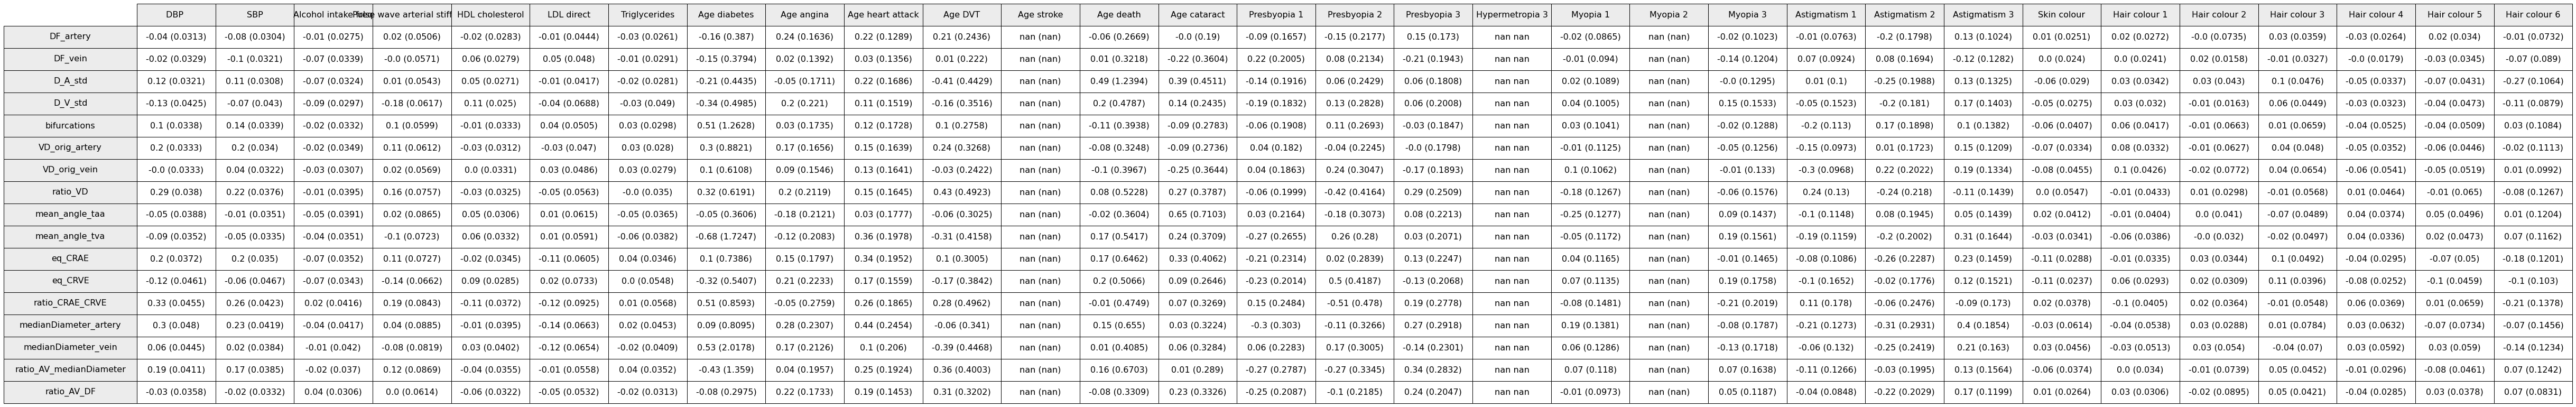

In [77]:
#print(df_reducida.columns, df_std.columns)
df = df_reducida.astype(str) + ' ' + df_std.astype(str)

rcolors = plt.cm.Greys(np.full(len(df.index), 0.15))
ccolors = plt.cm.Greys(np.full(len(df.columns), 0.15))
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
#create table
table = ax.table(cellText=df.values, 
                 rowColours=rcolors,
                 colLabels=df.columns, 
                 rowLabels=df.index,
                 colColours=ccolors,
                 rowLoc='center',
                 colLoc='center',
                 cellLoc='center',
                 #cellColours=plt.cm.coolwarm(df.values, alpha=0.2),
                 loc='center',
                 fontsize=16,
                 colWidths=[0.12 for x in df.columns])
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(3.7, 3.5) # make table a little bit larger
fig.tight_layout()
#plt.show()
fig.savefig(save_dir+str(DATE)+'_'+'ventile'+str(ventile_num)+'_diseases_gcorr.pdf', bbox_inches='tight',
            dpi=250)

print('todo ok')
print(save_dir+str(DATE)+'_'+'ventile'+str(ventile_num)+'_diseases_gcorr.pdf')

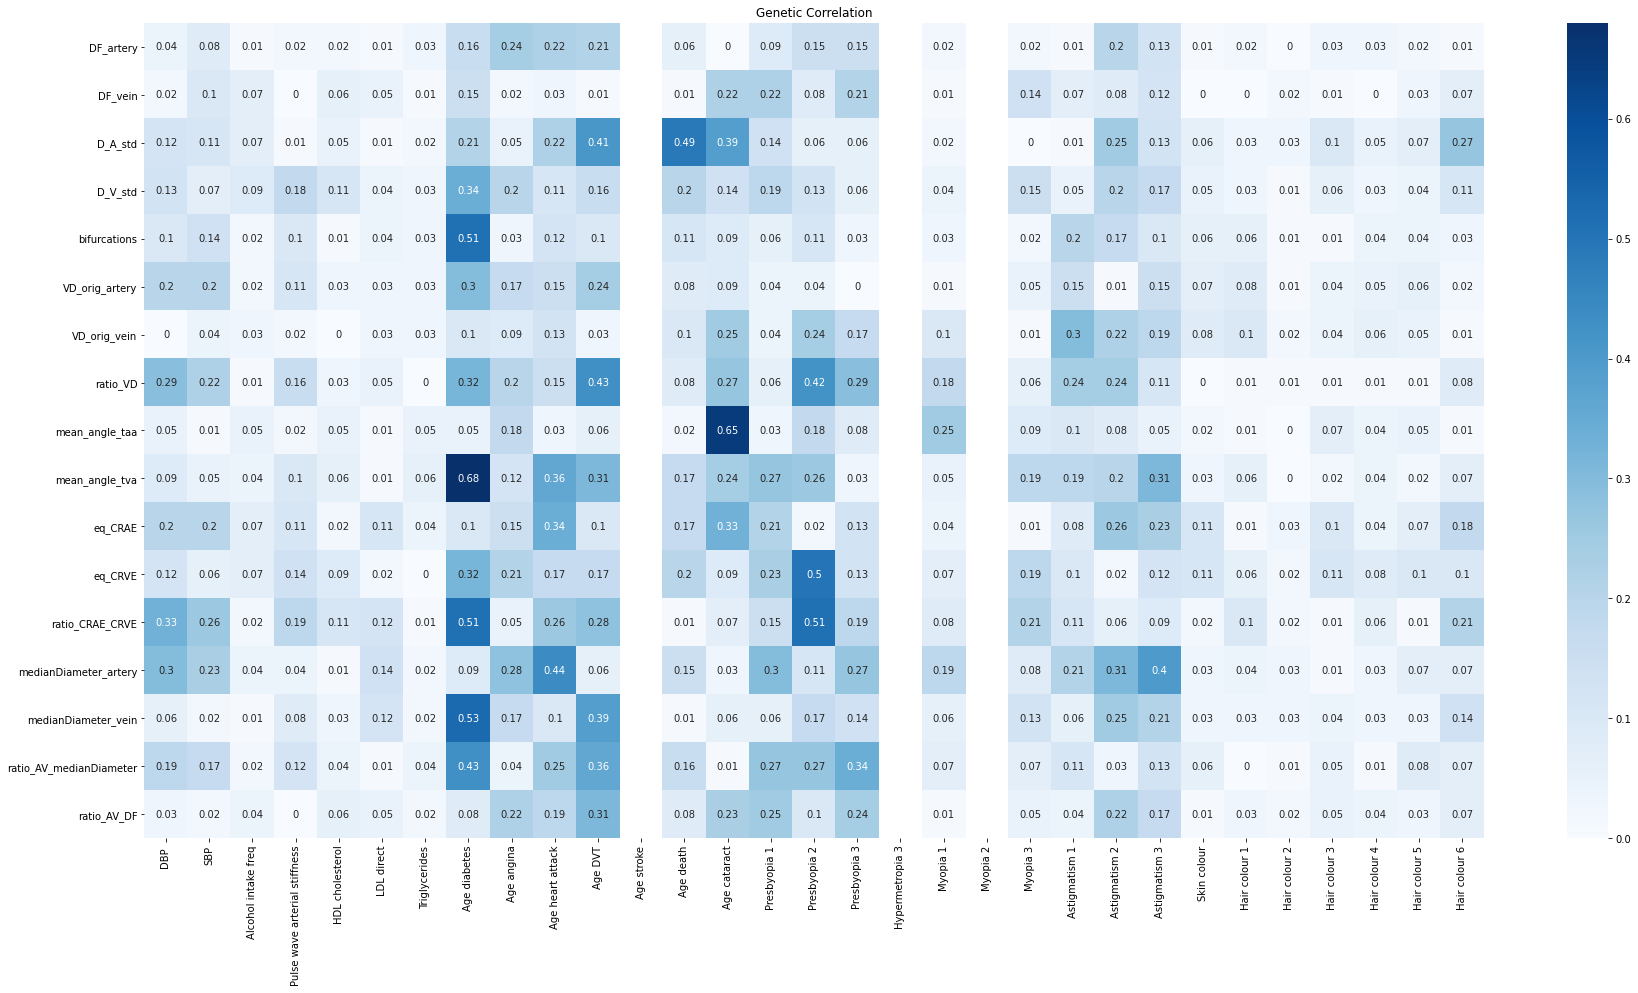

In [84]:
##### PLOT

plt.figure(figsize=(30,15))
#plt.figure(figsize=(10,10))
sb.heatmap(abs(df_reducida),cmap="Blues",annot=True)
#sb.heatmap(df2,vmin=0, vmax=1,cmap="Blues",annot=True)
plt.title('Genetic Correlation')
plt.savefig(save_dir+str(DATE)+'_'+'ventile'+str(ventile_num)+'_heatmap_diseases_gcorr.pdf', bbox_inches='tight',
            dpi=250)


In [ ]:
df_corr = df_corr.astype(float)
df_reducida = df_corr
df_reducida df.drop(index='cow', columns='small') 
df.drop(index=('falcon', 'weight'))

In [371]:
### replace nan by 0
df_corr= df_corr.replace(np.nan, 0)
df_corr

,tau1_artery__munged.sumstats.gz,tau1_vein__munged.sumstats.gz,D_A_std__munged.sumstats.gz,D_V_std__munged.sumstats.gz,bifurcations__munged.sumstats.gz,VD_orig_artery__munged.sumstats.gz,VD_orig_vein__munged.sumstats.gz,ratio_VD__munged.sumstats.gz,mean_angle_taa__munged.sumstats.gz,mean_angle_tva__munged.sumstats.gz,...,medianDiameter_artery__munged.sumstats.gz,medianDiameter_vein__munged.sumstats.gz,ratio_AV_medianDiameter__munged.sumstats.gz,ratio_AV_DF__munged.sumstats.gz,4079_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,4080_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,2976_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,3627_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,3894_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,4700_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz
tau1_artery__munged.sumstats.gz,1.0000,0.4987,0.1038,0.0227,0.0343,0.1300,0.0762,0.0903,0.1664,0.1346,...,0.1627,0.0051,0.1198,0.8172,-0.0057,-0.0251,0.6778,-0.0978,0.0399,0.0166
tau1_vein__munged.sumstats.gz,0.4987,1.0000,-0.1154,-0.2009,0.2541,0.2928,0.2915,0.0641,0.1431,0.1538,...,-0.0405,-0.2854,0.2437,-0.0902,-0.1813,-0.1365,0.4090,0.0399,-0.3535,0.1290
D_A_std__munged.sumstats.gz,0.1038,-0.1154,1.0000,0.6239,-0.1590,-0.0029,-0.1644,0.1399,0.2218,0.1820,...,0.6489,0.6273,-0.0647,0.1774,0.2475,0.1122,0.7187,0.0870,0.1520,0.0994
D_V_std__munged.sumstats.gz,0.0227,-0.2009,0.6239,1.0000,-0.1588,-0.0628,-0.0214,-0.0883,0.1964,0.3378,...,0.3210,0.5025,-0.2109,0.1411,0.0716,-0.0369,0.4115,-0.0651,-0.2221,0.2013
bifurcations__munged.sumstats.gz,0.0343,0.2541,-0.1590,-0.1588,1.0000,0.8892,0.9350,0.1344,0.0854,0.0276,...,-0.0918,-0.6664,0.5385,-0.1173,0.2600,0.3754,0.2846,-0.1783,-0.7069,-0.3737
VD_orig_artery__munged.sumstats.gz,0.1300,0.2928,-0.0029,-0.0628,0.8892,1.0000,0.7941,0.5069,0.1309,0.0351,...,0.2513,-0.4938,0.6710,-0.0465,0.2095,0.3631,0.3770,0.0314,-0.5066,-0.1232
VD_orig_vein__munged.sumstats.gz,0.0762,0.2915,-0.1644,-0.0214,0.9350,0.7941,1.0000,-0.1177,0.0837,0.0440,...,-0.1308,-0.5882,0.4333,-0.0976,0.0412,0.3157,0.2098,-0.1365,-0.4047,-0.2557
ratio_VD__munged.sumstats.gz,0.0903,0.0641,0.1399,-0.0883,0.1344,0.5069,-0.1177,1.0000,0.0733,-0.0295,...,0.5233,-0.0421,0.4866,0.0501,0.2195,0.1813,0.3760,0.1175,-0.4310,0.1461
mean_angle_taa__munged.sumstats.gz,0.1664,0.1431,0.2218,0.1964,0.0854,0.1309,0.0837,0.0733,1.0000,0.6474,...,0.0418,0.1375,-0.1099,0.0939,0.0372,0.1604,0.7349,-0.1588,-0.1355,0.0244
mean_angle_tva__munged.sumstats.gz,0.1346,0.1538,0.1820,0.3378,0.0276,0.0351,0.0440,-0.0295,0.6474,1.0000,...,0.1344,0.0215,0.0781,0.0437,0.3928,0.2453,-0.2726,-0.1206,0.5939,0.6705


Text(0.5, 1.0, 'Genetic Correlation')

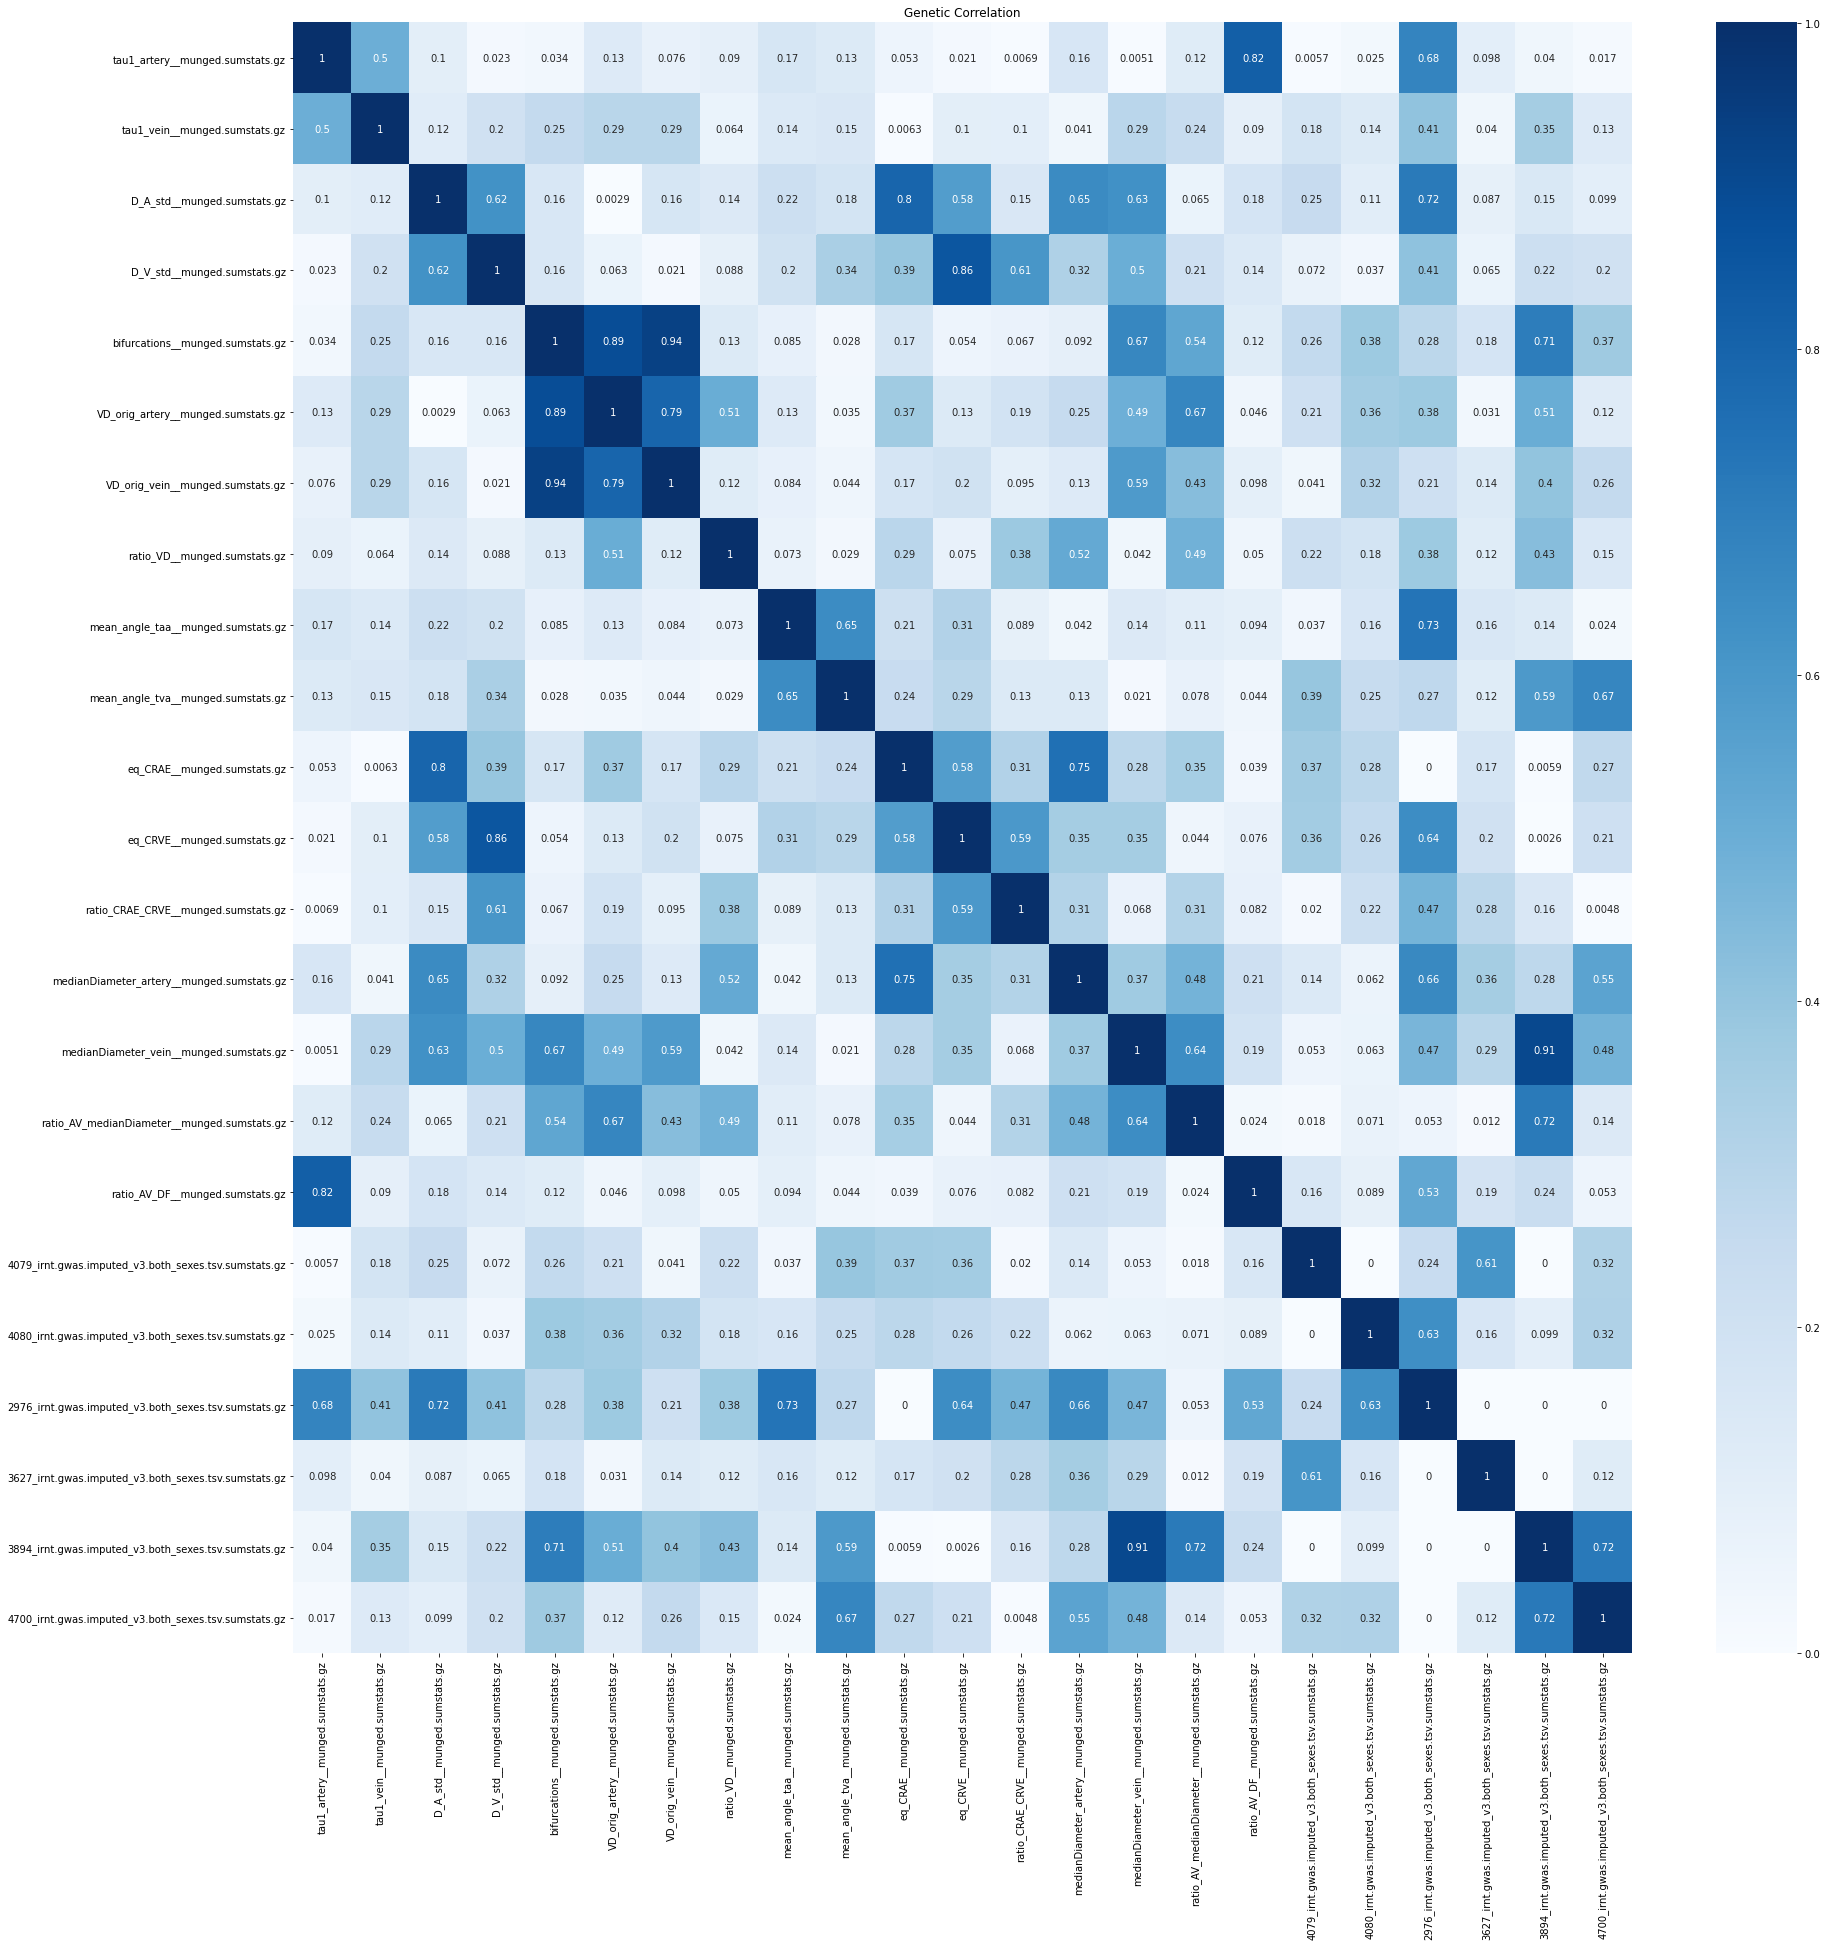

In [373]:
#### gen corr
#df_aux_.rename(diseases_traits, axis=1)
    #columns = {'4079_irnt':'DBP', '4080_irnt':'SBP', '4700_irnt':'cataract','4056_irnt':'stroke', '4012_irnt':'DVT', '40007_irnt':'age_death', '3894_irnt':'heart_attack', '3627_irnt':'angina', '2976_irnt':'diabetes', '21021_irnt':'wave_arterial'}, inplace = True)

plt.figure(figsize=(30,30))
#plt.figure(figsize=(10,10))
sb.heatmap(abs(df_corr),cmap="Blues",annot=True)
#sb.heatmap(df2,vmin=0, vmax=1,cmap="Blues",annot=True)
plt.title('Genetic Correlation')
#plt.savefig(save_path +'diseases_gcorr.jpg')



In [357]:
df_aux_ = df_corr
df_aux_= df_aux_.rename(diseases_traits, axis=1)
df_aux_

,tau1_artery__munged.sumstats.gz,tau1_vein__munged.sumstats.gz,D_A_std__munged.sumstats.gz,D_V_std__munged.sumstats.gz,bifurcations__munged.sumstats.gz,VD_orig_artery__munged.sumstats.gz,VD_orig_vein__munged.sumstats.gz,ratio_VD__munged.sumstats.gz,mean_angle_taa__munged.sumstats.gz,mean_angle_tva__munged.sumstats.gz,...,4080_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,4080_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,2976_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,2976_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,3627_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,3627_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,3894_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,3894_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,4700_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz,4700_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz
tau1_artery__munged.sumstats.gz,1.0000,0.4987,0.1038,0.0227,0.0343,0.1300,0.0762,0.0903,0.1664,0.1346,...,-0.0251,-0.0121,0.4014,0.6778,-0.0978,-0.1023,0.0399,-0.0009,0.0166,0.0884
tau1_vein__munged.sumstats.gz,0.4987,1.0000,-0.1154,-0.2009,0.2541,0.2928,0.2915,0.0641,0.1431,0.1538,...,-0.1365,-0.1633,0.2280,0.4090,0.0399,0.0157,-0.3535,-0.3612,0.1290,0.1586
D_A_std__munged.sumstats.gz,0.1038,-0.1154,1.0000,0.6239,-0.1590,-0.0029,-0.1644,0.1399,0.2218,0.1820,...,0.1122,0.1045,0.5699,0.7187,0.0870,0.1189,0.1520,0.2052,0.0994,0.2258
D_V_std__munged.sumstats.gz,0.0227,-0.2009,0.6239,1.0000,-0.1588,-0.0628,-0.0214,-0.0883,0.1964,0.3378,...,-0.0369,-0.0204,0.1876,0.4115,-0.0651,-0.0658,-0.2221,-0.1944,0.2013,0.3465
bifurcations__munged.sumstats.gz,0.0343,0.2541,-0.1590,-0.1588,1.0000,0.8892,0.9350,0.1344,0.0854,0.0276,...,0.3754,0.3601,0.1148,0.2846,-0.1783,-0.2476,-0.7069,-0.5948,-0.3737,-0.4134
VD_orig_artery__munged.sumstats.gz,0.1300,0.2928,-0.0029,-0.0628,0.8892,1.0000,0.7941,0.5069,0.1309,0.0351,...,0.3631,0.3428,0.2589,0.3770,0.0314,-0.0288,-0.5066,-0.3594,-0.1232,-0.0935
VD_orig_vein__munged.sumstats.gz,0.0762,0.2915,-0.1644,-0.0214,0.9350,0.7941,1.0000,-0.1177,0.0837,0.0440,...,0.3157,0.3110,0.1300,0.2098,-0.1365,-0.1875,-0.4047,-0.3045,-0.2557,-0.3396
ratio_VD__munged.sumstats.gz,0.0903,0.0641,0.1399,-0.0883,0.1344,0.5069,-0.1177,1.0000,0.0733,-0.0295,...,0.1813,0.1607,0.2615,0.3760,0.1175,0.0931,-0.4310,-0.3450,0.1461,0.2756
mean_angle_taa__munged.sumstats.gz,0.1664,0.1431,0.2218,0.1964,0.0854,0.1309,0.0837,0.0733,1.0000,0.6474,...,0.1604,0.1243,0.4428,0.7349,-0.1588,-0.1305,-0.1355,-0.2237,0.0244,-0.2390
mean_angle_tva__munged.sumstats.gz,0.1346,0.1538,0.1820,0.3378,0.0276,0.0351,0.0440,-0.0295,0.6474,1.0000,...,0.2453,0.2345,-0.1246,-0.2726,-0.1206,-0.1345,0.5939,0.5234,0.6705,0.6834


# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


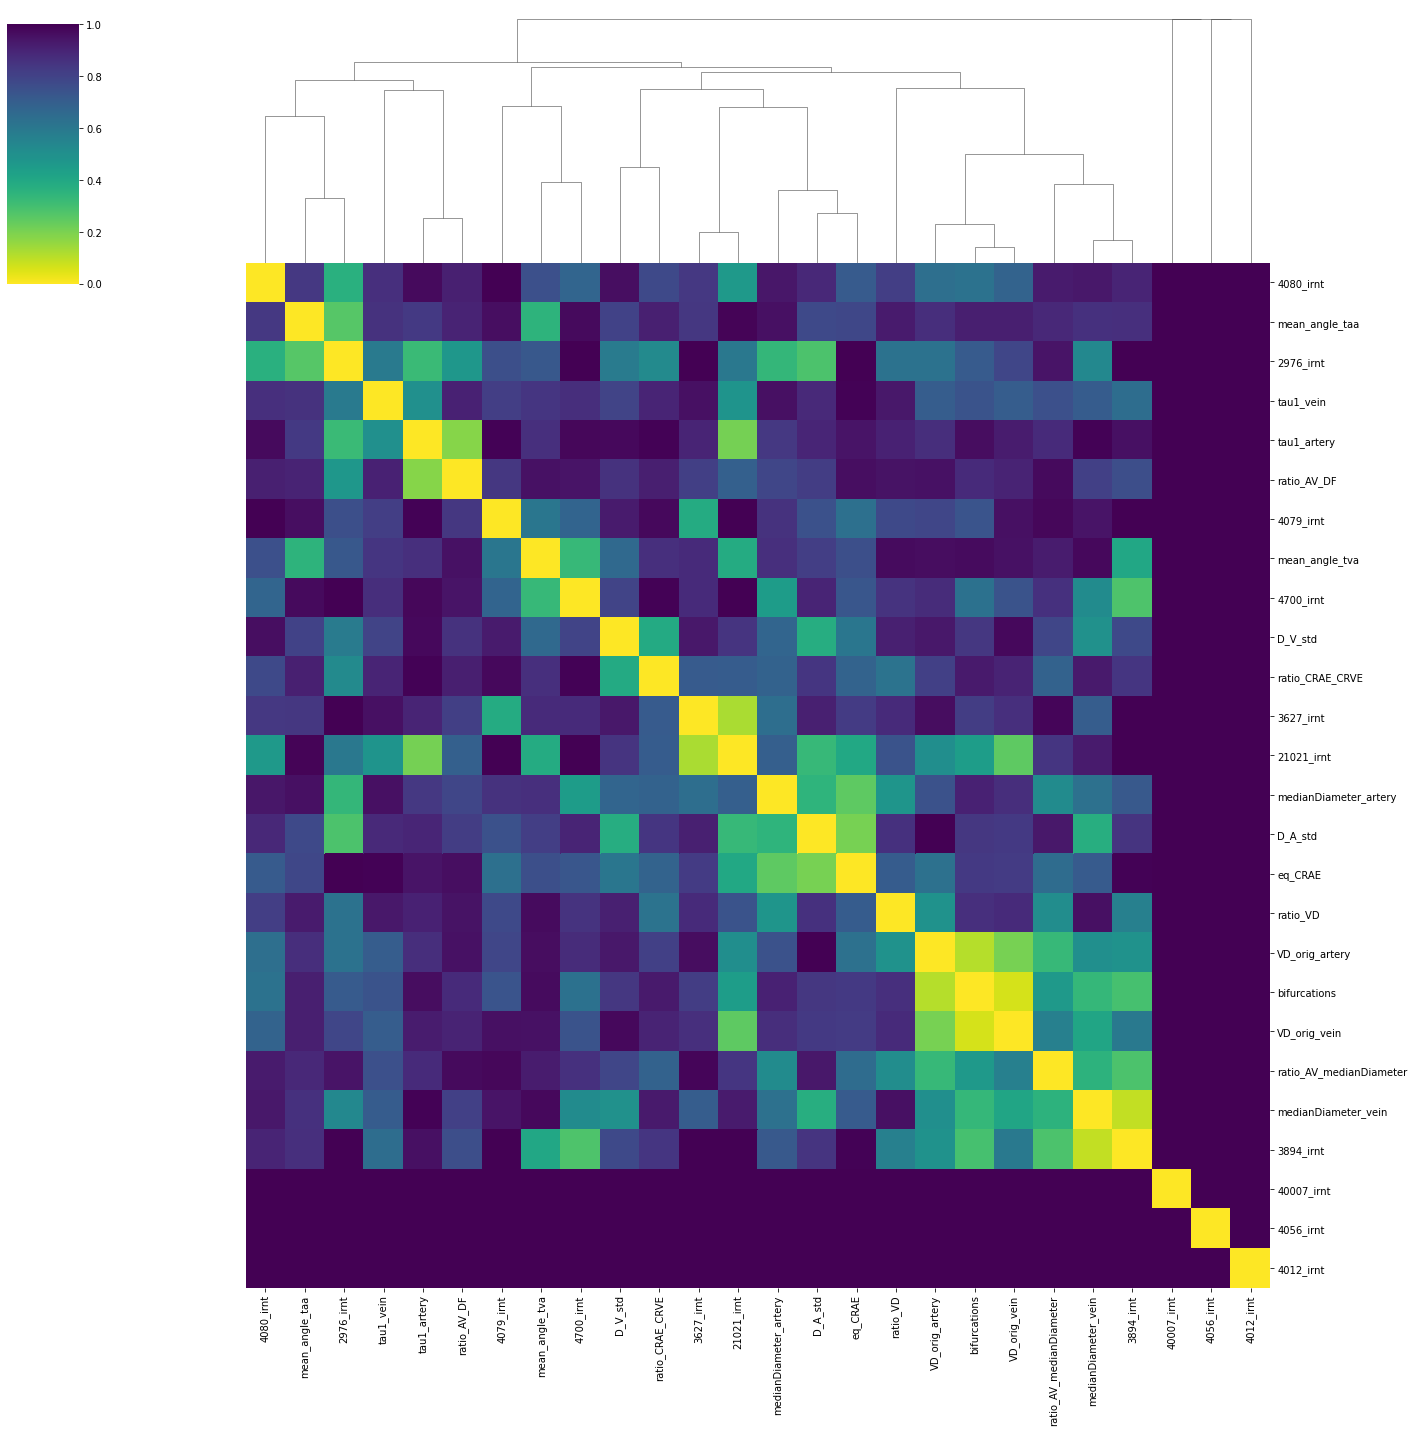

In [89]:
import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
### You need to: 
## - delete the nans, 
## - diagonal to 0, and
## - abs(linkage)

df_2_nan = df_corr
df_2_nan=df_2_nan.replace(np.nan,1)
#print('Count nans: ', df2.isna().sum().sum(), df_2_nan.isna().sum().sum())
# pairwise distance: define distance between two perfectly negatively correlated traits as 0
df_otro = 1 - abs(df_2_nan) 
## diagonal same value:
df_otro.values[[np.arange(df_otro.shape[0])]*2] = 0

linkage = hc.linkage(sp.distance.squareform(df_otro), method='average')
lik_abs= abs(linkage)
h = sns.clustermap(df_otro, row_linkage=lik_abs, col_linkage=lik_abs, cmap=cm.get_cmap('viridis_r'), figsize=(20,20), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)
#plt.savefig('/SSD/home/sofia/retina-phenotypes/complementary/GWAS_postprocessing/ldsr_correlation/diseases_12_08_2022_gcorrimagen.jpg')